In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import nltk
import re
import matplotlib.pyplot as plt
import dgl
import itertools

from allennlp.modules.elmo import Elmo, batch_to_ids
from eunjeon import Mecab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from dgl.dataloading import GraphDataLoader
from sklearn.metrics import accuracy_score, recall_score, f1_score

plt.rc('font', family='Malgun Gothic')

In [2]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
data_dir = '../analysis_files/files/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# 감성대화말뭉치(최종데이터)_Training.csv 파일을 pandas로 읽어옵니다.
df = pd.read_csv(os.path.join(data_dir, '감성대화말뭉치(최종데이터)_Training2.csv'), encoding='cp949')
df = df[['사람문장1', '시스템문장1', '사람문장2','시스템문장2','사람문장3','시스템문장3','감정_대분류', '상황키워드']]

In [5]:
# ELMo 모델 초기화
options_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json"
weight_file = "../analysis_files/elmo/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5"
elmo = Elmo(options_file, weight_file, num_output_representations=1)

# mecab 모델 다운로드
mecab = Mecab()

# elmo 모델 다운로드
elmo = elmo.to(device)

In [6]:
# 한국어 문장 형태소 분리 함수
def tokenize_korean_sentence(sentence):
    tokens = mecab.morphs(sentence)
    return tokens

In [7]:
def preprocessing(sentences) :
    sentences = re.sub(r'\([^)]*\)', '', sentences)
    sentences = sentences.replace('.', '')
    sentences = re.sub(r'[^가-힣\s]', '', sentences)
    sentences = re.sub(r'\b(?:cm|km|etc)\b', '', sentences)
    return sentences

In [8]:
def extract_sentence_features(sentence):
    # TF-IDF 벡터화 객체 생성
    tfidf_vectorizer = TfidfVectorizer(token_pattern=r"(?u)\b\w+\b")

    # 문장 길이
    sentence_length = len(sentence)

    # 품사 개수
    tokens = mecab.pos(sentence)
    pos_tags = [tag for _, tag in tokens]
    num_pos_tags = len(pos_tags)

    # 명사 추출
    nouns = mecab.nouns(sentence)

    # TF-IDF 벡터화 및 상위 3개 단어 추출
    top_words = ['', '', '']  # 단어가 없을 경우 빈 문자열로 초기화
    top_scores = [0.0, 0.0, 0.0]  # 단어가 없을 경우 TF-IDF 스코어를 0.0으로 초기화
    top_word_vectors = np.zeros((3,))  # 단어가 없을 경우 0 벡터로 초기화

    if nouns:
        tfidf_matrix = tfidf_vectorizer.fit_transform(nouns)
        feature_names = tfidf_vectorizer.get_feature_names_out()
        tfidf_scores = tfidf_matrix.toarray()[0]
        top_indices = np.argsort(tfidf_scores)[-3:][::-1]  # 상위 3개 단어의 인덱스 추출
        top_words = [feature_names[index] for index in top_indices]  # 상위 3개 단어 추출
        top_scores = [tfidf_scores[index] for index in top_indices]  # 상위 3개 단어의 TF-IDF 스코어 추출
        top_word_vectors = [tfidf_matrix.toarray()[0][index] for index in top_indices]  # 상위 3개 단어의 벡터값 추출

    return sentence_length, num_pos_tags, top_words, top_scores, top_word_vectors

In [9]:
data_train = []
data_test = []

# 레이블을 정수형으로 변환
label_mapping_emotion = {'기쁨': 0, '당황': 1, '분노': 2, '불안' : 3, '상처' : 4,'슬픔' : 5}  # 감정에 해당하는 레이블과 정수 매핑
label_mapping_situation = {'가족관계': 0, '건강': 1, '건강,죽음': 2, '대인관계' : 3, '대인관계(부부, 자녀)' : 4, '연애,결혼,출산' : 5, '재정' : 6, 
                        '재정,은퇴,노후준비' : 7, '직장, 업무 스트레스' : 8, '진로,취업,직장' : 9, '학교폭력/따돌림' : 10, '학업 및 진로' : 11}  # 상황에 해당하는 레이블과 정수 매핑

In [10]:
# 그래프 생성 및 노드 추가
graphs = []
for _, row in df.iterrows():
    G = nx.Graph()
    sentences = [row['사람문장1'], row['시스템문장1'], row['사람문장2'], row['시스템문장2'], row['사람문장3'], row['시스템문장3']]

    for i, sentence in enumerate(sentences):
        print(sentence)
        if pd.isna(sentence):  # NaN 값 처리
            sentence_embedding = torch.zeros(1024).to(device)  # 0 벡터로 처리
        else:
            sentence = preprocessing(sentence)
            # 문장을 형태소로 분리
            tokens = tokenize_korean_sentence(sentence)
            # 문장을 ELMo 임베딩으로 변환
            character_ids = batch_to_ids([tokens]).to(device)  # GPU로 이동
            embeddings_output = elmo(character_ids)  # GPU로 이동
            sentence_embedding = torch.mean(embeddings_output["elmo_representations"][0], dim=0).to('cpu')
            # 문장 특징 추출
            sentence_length, num_pos_tags, top_words, top_scores, top_word_vectors = extract_sentence_features(sentence)

            # 변환된 특징 데이터를 텐서로 변환
            sentence_embedding_tensor = torch.tensor(sentence_embedding)
            length_tensor = torch.tensor(sentence_length)
            pos_tags_tensor = torch.tensor(num_pos_tags)
            top_word_vectors_tensor = torch.tensor(top_word_vectors)

        G.add_node(i)

        # 노드 특성 추가
        G.nodes[i]['feature'] = sentence_embedding_tensor
        G.nodes[i]['length'] = length_tensor
        G.nodes[i]['pos_tags'] = pos_tags_tensor
        G.nodes[i]['top_word_vectors'] = top_word_vectors_tensor

        if i > 0:
            # 엣지 정보 생성
            edge_index = i-1  # 엣지 번호
            G.add_edge(i-1, i, edge_index=edge_index)  # 엣지 정보는 인덱스로 설정

            # 엣지 특성 추가
            G.edges[i-1, i]['edge_feature'] = edge_index  # 엣지 특성 설정

    # 감정 및 상황 레이블 할당
    y_emotion = label_mapping_emotion[row['감정_대분류']]
    y_situation = label_mapping_situation[row['상황키워드']]

    graphs.append((G, y_emotion, y_situation))

건강이 갈수록 안 좋아지고 있는데 자식들이 걱정할까봐 신경이 쓰여.


C:\Users\User\AppData\Local\Temp\ipykernel_27300\3207222834.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sentence_embedding_tensor = torch.tensor(sentence_embedding)


건강 악화로 인해 자녀들이 걱정할까 봐 신경이 쓰이시는군요.
응. 어제는 조금만 움직였는데도 몸에 무리가 간 건지 너무 힘들었어.
몸이 힘드셨군요. 그렇다면 상황을 극복하기 위해 어떻게 해야 할까요?
운동을 열심히 해서 조금이라도 더 튼튼한 몸을 만들어 자식들이 걱정할 일을 만들지 않아야겠어.
운동으로 몸을 관리해서 걱정이 사라지셨으면 좋겠어요.
나이를 먹으니 아프지 않은 곳이 없어. 힘들어
많이 힘드시군요. 힘내세요.
그래도 가족들을 위해서 열심히 일해야겠지?
열심히 일하실 거군요. 어떻게 하실 건가요?
열심히 일해야지 그래도.
언제든지 응원하겠습니다.
언니가 화장품 빌려 준다 하고서는 안 빌려줘서 화가 나.
언니가 화장품을 안 빌려줘서 화가 나시겠어요.
난 지난번에 용돈까지 빌려줬는데 어떻게 약속을 안 지키지?
지난번에 용돈까지 빌려줬는데 약속을 안 지켰군요. 이 상황을 변화시키기 위해 무엇을 할 수 있을까요?
언니랑 얘기를 해봐야겠어.
언니와의 대화가 잘 풀리기를 바라요.
아내가 나보다 먼저 세상을 떠나게 됐어. 너무 서러워.
아내와 사별을 하여 너무 마음 아프고 서럽겠군요.
야근이 많은 일을 하다 보니 가족들에게 소홀해서 아내가 떠나기 전 제대로 얼굴도 보지 못했어.
지금의 기분에서 조금이라도 벗어나기 위해 가장 자신 있게 해 볼 수 있는 일은 무엇이 있을까요?
미리 떠난 아내를 대신해 지금부터라도 일보다는 가정에 충실한 남편이 되겠어.
이 상황을 잘 이겨내시고 앞으로는 일보다 가정에 충실해질 수 있길 바라요.
아내가 갑자기 쓰려져서 병원에 가려고 급하게 나왔는데 집에서 입던 차림 그대로 나온 걸 몰랐어.
옷을 갈아입지 않고 나오셨군요. 부끄러웠겠어요.
옷을 어떻게 구할지 고민이야.
잠옷차림인 것을 들키지 않을 방법이 뭐가 있을까요?
외투를 입고 옷을 사러 다녀와야지.
옷도 무사히 사시고 아내 분도 쾌차하시길 바라요.
요즘 진학 상담 때문에 선생님이 예민하셔. 그래서 반 아이들도 나도 조심스러워.
선생님이 예민하신 것 때문에 조심스럽게 눈치를 보고 계시

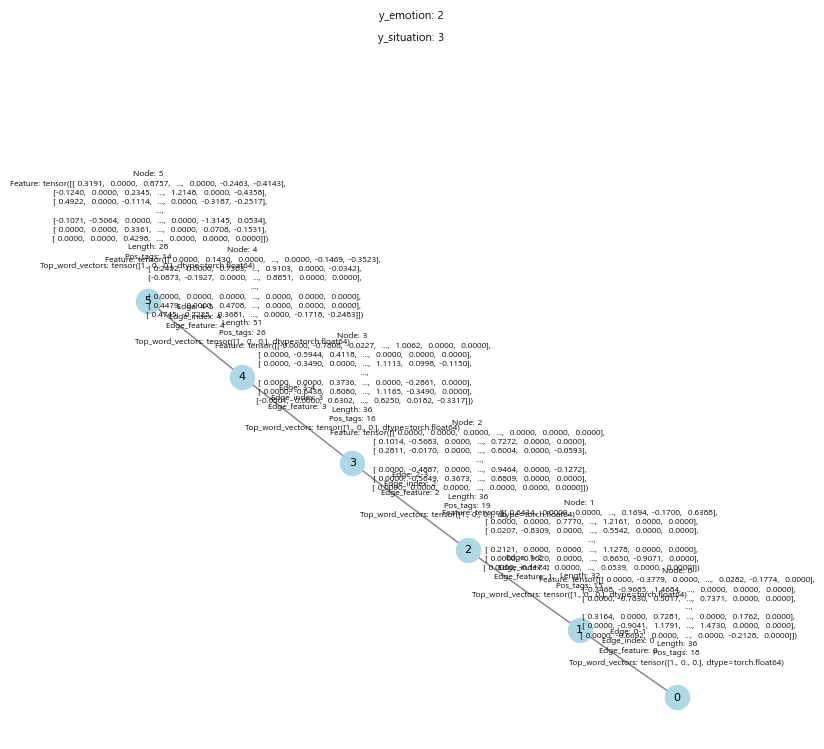

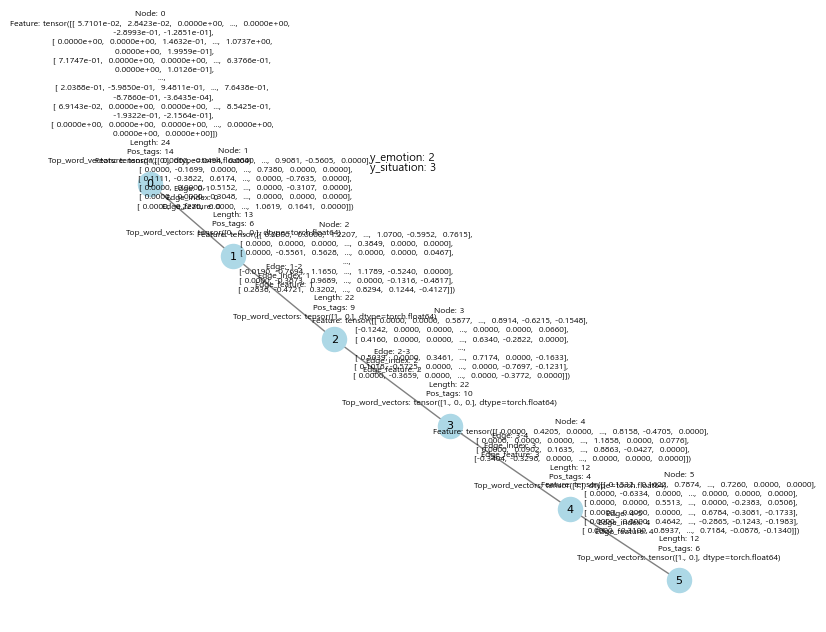

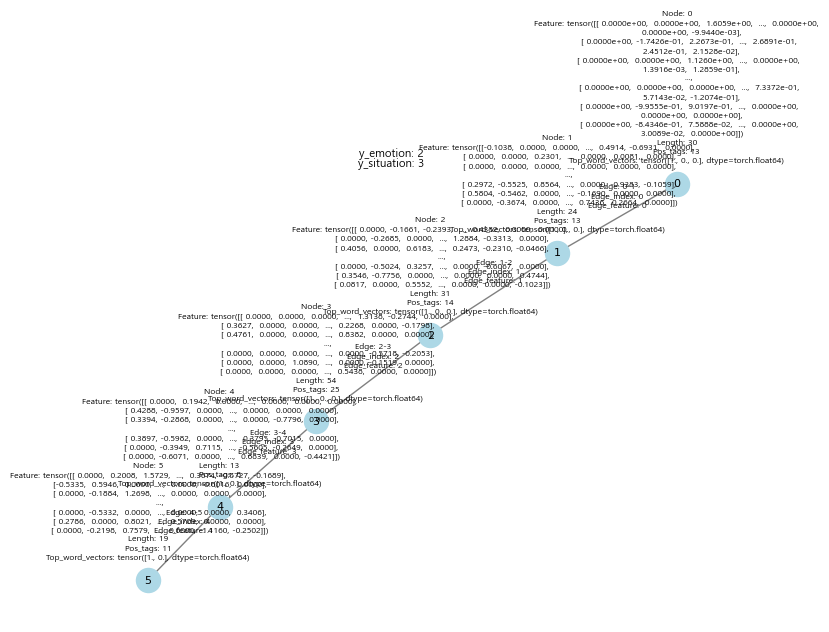

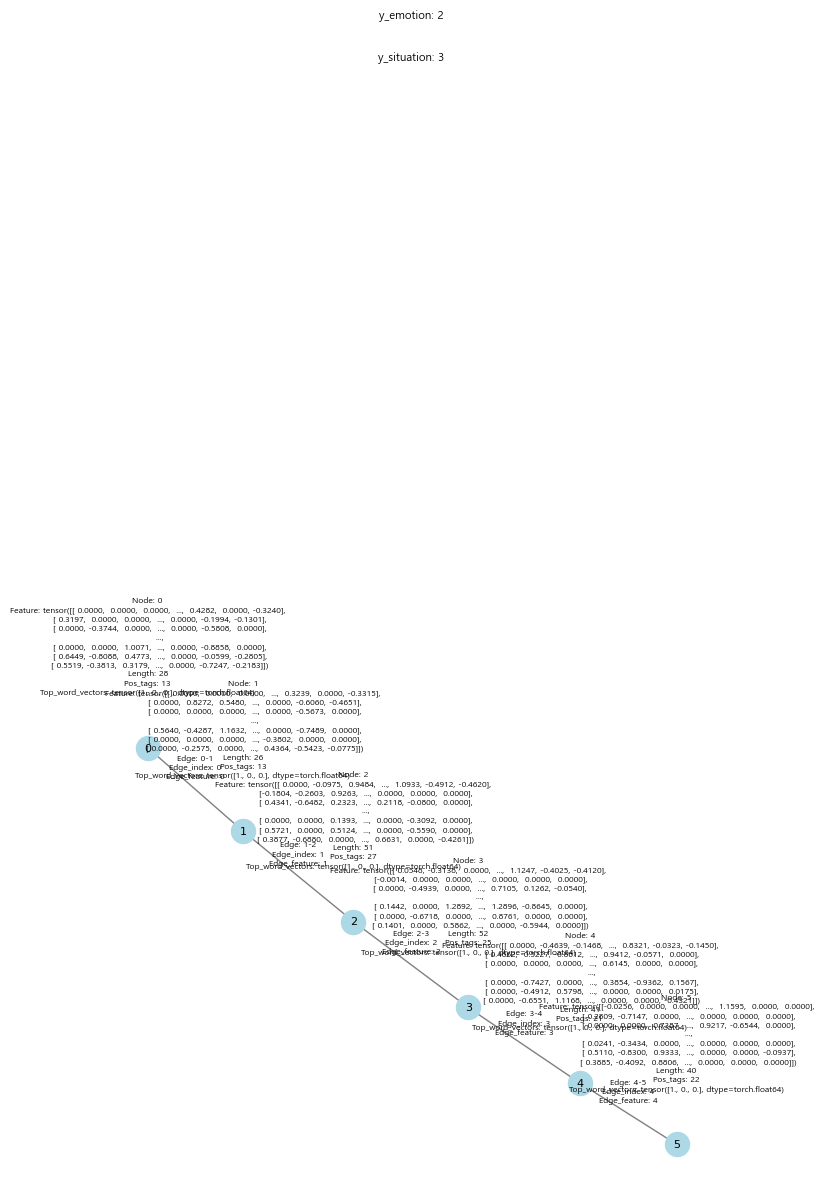

In [11]:
# 그래프 시각화
for i in range(10):  # 3개의 그래프만 표시
    graph, _, _ = graphs[i]  # graph, y_emotion, y_situation 중 graph만 사용
    pos = nx.spring_layout(graph)  # 그래프의 노드 위치 결정
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=8)  # 그래프 그리기
    node_attributes = graph.nodes(data=True)  # 노드의 속성 정보 가져오기
    edge_attributes = graph.edges(data=True)  # 엣지의 속성 정보 가져오기


    for node, attributes in node_attributes:
        x, y = pos[node]
        # 노드 속성 표시
        attribute_text = f"Node: {node}\n"
        for attr_name, attr_value in attributes.items():
            attribute_text += f"{attr_name.capitalize()}: {attr_value}\n"
        plt.text(x, y + 0.05, s=attribute_text, fontsize=6, ha='center', va='bottom')

    for edge in edge_attributes:
        x1, y1 = pos[edge[0]]
        x2, y2 = pos[edge[1]]
        # 엣지 속성 표시
        attribute_text = f"Edge: {edge[0]}-{edge[1]}\n"
        for attr_name, attr_value in edge[2].items():
            attribute_text += f"{attr_name.capitalize()}: {attr_value}\n"
        plt.text((x1 + x2) / 2, (y1 + y2) / 2, s=attribute_text, fontsize=6, ha='center', va='bottom')

    # y_emotion과 y_situation 레이블 표시
    y_emotion = label_mapping_emotion[row['감정_대분류']]
    y_situation = label_mapping_situation[row['상황키워드']]
    plt.text(0, 1.1, s=f"y_emotion: {y_emotion}", fontsize=8, ha='center', va='bottom')
    plt.text(0, 1.05, s=f"y_situation: {y_situation}", fontsize=8, ha='center', va='bottom')

    plt.show()

In [12]:
dgl_graphs = []
for (G, y_emotion, y_situation) in graphs:
    # Convert NetworkX graph to DGL graph
    dgl_G = dgl.DGLGraph(G)
    # 노드 및 엣지 속성을 graph.ndata 및 graph.edata에 저장
    num_nodes = len(G.nodes())
    dgl_G.ndata['feature'] = torch.zeros(num_nodes, 1024)
    dgl_G.ndata['length'] = torch.zeros(num_nodes)
    dgl_G.ndata['pos_tags'] = torch.zeros(num_nodes)
    dgl_G.ndata['top_word_vectors'] = torch.zeros(num_nodes, 3)  # top_word_vectors의 크기를 3으로 고정
    dgl_G.edata['edge_feature'] = torch.zeros(10)

    for i in G.nodes():
        feature = G.nodes[i]['feature']
        if feature.shape != (1024,):
            # feature의 크기가 (1024,)가 아닌 경우, 1024 차원의 평균을 취하여 크기를 (1024,)로 축소
            feature = torch.mean(feature, dim=0)
        dgl_G.ndata['feature'][i] = feature
        dgl_G.ndata['length'][i] = G.nodes[i]['length']
        dgl_G.ndata['pos_tags'][i] = G.nodes[i]['pos_tags']
        top_word_vectors = G.nodes[i]['top_word_vectors']
        if top_word_vectors.shape != (3,):
            # top_word_vectors의 크기가 (3,)가 아닌 경우, 3 차원으로 크기를 고정하고 0으로 채워진 텐서로 변환
            top_word_vectors = torch.tensor(top_word_vectors)
            expanded_top_word_vectors = torch.zeros(3)
            expanded_top_word_vectors[:top_word_vectors.size(0)] = top_word_vectors
            top_word_vectors = expanded_top_word_vectors
        dgl_G.ndata['top_word_vectors'][i] = top_word_vectors

    for i, j in G.edges():
        dgl_G.edata['edge_feature'][j-1] = G.edges[i, j]['edge_feature']

    dgl_G.ndata['y_emotion'] = torch.tensor([y_emotion] * num_nodes)
    dgl_G.ndata['y_situation'] = torch.tensor([y_situation] * num_nodes)

    dgl_graphs.append(dgl_G)

c:\Users\User\anaconda3\envs\torch\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(
C:\Users\User\AppData\Local\Temp\ipykernel_27300\3657086150.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_word_vectors = torch.tensor(top_word_vectors)


In [13]:
for i in range(4):
    graph = dgl_graphs[i]
    print(f"Graph {i+1}:")
    print("Number of nodes:", graph.number_of_nodes())
    print("Number of edges:", graph.number_of_edges())
    print("Node features:")
    print(graph.ndata)
    print("Edge features:")
    print(graph.edata)
    print()

Graph 1:
Number of nodes: 6
Number of edges: 10
Node features:
{'feature': tensor([[ 0.0322, -0.4254,  0.6795,  ...,  0.2255, -0.1968,  0.0290],
        [ 0.1164, -0.2445,  0.2741,  ...,  0.5141, -0.3576,  0.0057],
        [ 0.2283, -0.3058,  0.1108,  ...,  0.3762, -0.1283, -0.0072],
        [ 0.0759, -0.2775,  0.2333,  ...,  0.5266, -0.1177, -0.0250],
        [ 0.2476, -0.3589,  0.2752,  ...,  0.4167, -0.1513, -0.0843],
        [ 0.1152, -0.2332,  0.2343,  ...,  0.3354, -0.2504, -0.1603]]), 'length': tensor([36., 32., 36., 36., 51., 28.]), 'pos_tags': tensor([18., 15., 19., 16., 26., 14.]), 'top_word_vectors': tensor([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]), 'y_emotion': tensor([1, 1, 1, 1, 1, 1]), 'y_situation': tensor([1, 1, 1, 1, 1, 1])}
Edge features:
{'edge_feature': tensor([0., 1., 2., 3., 4., 0., 0., 0., 0., 0.])}

Graph 2:
Number of nodes: 6
Number of edges: 10
Node features:
{'feature': tenso

In [26]:
# 데이터 분할
train_graphs, test_graphs = train_test_split(dgl_graphs, test_size=0.2, random_state=42)

In [27]:
class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = dgl.nn.GraphConv(input_dim, hidden_dim)
        self.conv2 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
        self.conv3 = dgl.nn.GraphConv(hidden_dim, hidden_dim)
        self.fc_emotion = nn.Linear(hidden_dim, output_dim['emotion'])
        self.fc_situation = nn.Linear(hidden_dim, output_dim['situation'])
        
    def forward(self, g):
        x = g.ndata['feature']
        # length = g.ndata['length']
        # pos_tags = g.ndata['pos_tags']
        # top_word_vectors = g.ndata['top_word_vectors']
        # edge_index = g.edata['edge_feature']

        x = self.conv1(g, x)
        x = F.relu(x)
        x = self.conv2(g, x)
        x = F.relu(x)
        x = self.conv3(g, x)
        x = F.relu(x)

        # x = dgl.mean_nodes(g, x)  # 그래프의 특성을 하나의 벡터로 요약

        # 속성들을 모델에 입력으로 추가
        # x = torch.cat([x, length, pos_tags, top_word_vectors], dim=1)

        emotion_out = self.fc_emotion(x)
        situation_out = self.fc_situation(x)

        return emotion_out, situation_out

In [28]:
# 학습 모델 초기화 및 손실 함수, 옵티마이저 설정
input_dim = 1024
hidden_dim = 128
output_dim = {'emotion': len(label_mapping_emotion), 'situation': len(label_mapping_situation)}
model = GCNModel(input_dim, hidden_dim, output_dim)
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [29]:
# 데이터 로더 생성
batch_size = 32
train_loader = GraphDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = GraphDataLoader(test_graphs, batch_size=batch_size, shuffle=True)


In [30]:
# 평가 함수 정의
def evaluate(model, dataloader):
    model.eval()
    y_true_emotion = []
    y_pred_emotion = []
    y_true_situation = []
    y_pred_situation = []

    with torch.no_grad():
        for batch in dataloader:
            g = batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']

            outputs_emotion, outputs_situation = model(g)
            _, predicted_emotion = torch.max(outputs_emotion, 1)
            _, predicted_situation = torch.max(outputs_situation, 1)
            y_true_emotion.extend(labels_emotion.tolist())
            y_pred_emotion.extend(predicted_emotion.tolist())
            y_true_situation.extend(labels_situation.tolist())
            y_pred_situation.extend(predicted_situation.tolist())

    accuracy_emotion = accuracy_score(y_true_emotion, y_pred_emotion)
    recall_emotion = recall_score(y_true_emotion, y_pred_emotion, average='macro')
    f1_emotion = f1_score(y_true_emotion, y_pred_emotion, average='macro')
    accuracy_situation = accuracy_score(y_true_situation, y_pred_situation)
    recall_situation = recall_score(y_true_situation, y_pred_situation, average='macro')
    f1_situation = f1_score(y_true_situation, y_pred_situation, average='macro')

    return accuracy_emotion, recall_emotion, f1_emotion, accuracy_situation, recall_situation, f1_situation



In [32]:
num_epochs = 1000
train_acc_emotion_list = []
train_acc_situation_list = []
test_acc_emotion_list = []
test_acc_situation_list = []

for epoch in range(num_epochs):
    model.train()
    
    for batch in test_loader:
        g = batch
        labels_emotion = g.ndata['y_emotion']
        labels_situation = g.ndata['y_situation']
        optimizer.zero_grad()
        outputs_emotion, outputs_situation = model(g)
        loss_emotion = loss_function(outputs_emotion, labels_emotion)
        loss_situation = loss_function(outputs_situation, labels_situation)
        loss = loss_emotion + loss_situation
        loss.backward()
        optimizer.step()
        
    for batch in train_loader:
        g = batch
        labels_emotion = g.ndata['y_emotion']
        labels_situation = g.ndata['y_situation']
        optimizer.zero_grad()
        outputs_emotion, outputs_situation = model(g)
        loss_emotion = loss_function(outputs_emotion, labels_emotion)
        loss_situation = loss_function(outputs_situation, labels_situation)
        loss = loss_emotion + loss_situation
        loss.backward()
        optimizer.step()

    # 학습 데이터에 대한 평가
    train_accuracy_emotion, train_recall_emotion, train_f1_emotion, train_accuracy_situation, train_recall_situation, train_f1_situation = evaluate(model, train_loader)
    # 테스트 데이터에 대한 평가
    test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)

    # Append accuracy values to the lists
    train_acc_emotion_list.append(train_accuracy_emotion)
    train_acc_situation_list.append(train_accuracy_situation)
    test_acc_emotion_list.append(test_accuracy_emotion)
    test_acc_situation_list.append(test_accuracy_situation)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Emotion Accuracy: {train_accuracy_emotion:.4f} Recall: {train_recall_emotion:.4f} F1-score: {train_f1_emotion:.4f}")
    print(f"Train Situation Accuracy: {train_accuracy_situation:.4f} Recall: {train_recall_situation:.4f} F1-score: {train_f1_situation:.4f}")
    print(f"Test Emotion Accuracy: {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
    print(f"Test Situation Accuracy: {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
    print()


Epoch 1/1000:
Train Emotion Accuracy: 0.2632 Recall: 0.2717 F1-score: 0.2653
Train Situation Accuracy: 0.2996 Recall: 0.2161 F1-score: 0.2280
Test Emotion Accuracy: 0.2621 Recall: 0.2694 F1-score: 0.2638
Test Situation Accuracy: 0.2974 Recall: 0.2150 F1-score: 0.2284

Epoch 2/1000:
Train Emotion Accuracy: 0.2679 Recall: 0.2821 F1-score: 0.2666
Train Situation Accuracy: 0.3002 Recall: 0.2201 F1-score: 0.2284
Test Emotion Accuracy: 0.2618 Recall: 0.2746 F1-score: 0.2599
Test Situation Accuracy: 0.2957 Recall: 0.2185 F1-score: 0.2260

Epoch 3/1000:
Train Emotion Accuracy: 0.2693 Recall: 0.2794 F1-score: 0.2719
Train Situation Accuracy: 0.3004 Recall: 0.2106 F1-score: 0.2231
Test Emotion Accuracy: 0.2637 Recall: 0.2727 F1-score: 0.2660
Test Situation Accuracy: 0.2966 Recall: 0.2075 F1-score: 0.2198

Epoch 4/1000:
Train Emotion Accuracy: 0.2587 Recall: 0.2788 F1-score: 0.2476
Train Situation Accuracy: 0.2946 Recall: 0.2227 F1-score: 0.2282
Test Emotion Accuracy: 0.2552 Recall: 0.2736 F1-sco

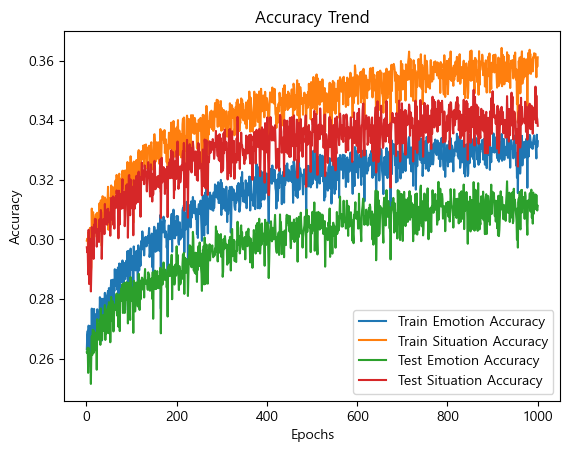

In [33]:
# Plotting the accuracy trend
epochs = range(1, num_epochs+1)

plt.plot(epochs, train_acc_emotion_list, label='Train Emotion Accuracy')
plt.plot(epochs, train_acc_situation_list, label='Train Situation Accuracy')
plt.plot(epochs, test_acc_emotion_list, label='Test Emotion Accuracy')
plt.plot(epochs, test_acc_situation_list, label='Test Situation Accuracy')

plt.title('Accuracy Trend')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import KFold

num_epochs = 200
k = 5 # K-Fold Cross Validation의 K 값 설정
batch_size = 32

# 데이터셋을 K-Fold로 분할
kf = KFold(n_splits=k, shuffle=True)

# K-Fold Cross Validation 반복
for fold, (train_idx, test_idx) in enumerate(kf.split(dgl_graphs)):
    print(f"Fold {fold+1}/{k}")

    # 데이터셋 분할
    train_graphs = [dgl_graphs[i] for i in train_idx]
    test_graphs = [dgl_graphs[i] for i in test_idx]

    # 모델 초기화 또는 이전 모델 로드
    if fold != 0:
        model = torch.load("saved_model.pt")  # 이전 모델 로드

    loss_function = nn.CrossEntropyLoss().to(device)
    
    # 데이터 로더 업데이트
    train_loader = GraphDataLoader(train_graphs, batch_size=batch_size, shuffle=True)
    test_loader = GraphDataLoader(test_graphs, batch_size=batch_size, shuffle=True)

    train_acc_emotion_list = []
    train_acc_situation_list = []
    test_acc_emotion_list = []
    test_acc_situation_list = []

    # 학습 및 평가 반복
    model.train()
    for epoch in range(num_epochs):
        for batch in train_loader:
            g =batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']
            optimizer.zero_grad()
            outputs_emotion, outputs_situation = model(g)
            loss_emotion = loss_function(outputs_emotion, labels_emotion)
            loss_situation = loss_function(outputs_situation, labels_situation)
            loss = loss_emotion + loss_situation
            loss.backward()
            optimizer.step()

        # 학습 데이터에 대한 평가
        model.eval()
        train_accuracy_emotion, train_recall_emotion, train_f1_emotion, train_accuracy_situation, train_recall_situation, train_f1_situation = evaluate(model, train_loader)
        # 테스트 데이터에 대한 평가
        test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)

        # Append accuracy values to the lists
        train_acc_emotion_list.append(train_accuracy_emotion)
        train_acc_situation_list.append(train_accuracy_situation)
        test_acc_emotion_list.append(test_accuracy_emotion)
        test_acc_situation_list.append(test_accuracy_situation)

        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Emotion Accuracy: {train_accuracy_emotion:.4f} Recall: {train_recall_emotion:.4f} F1-score: {train_f1_emotion:.4f}")
        print(f"Train Situation Accuracy: {train_accuracy_situation:.4f} Recall: {train_recall_situation:.4f} F1-score: {train_f1_situation:.4f}")
        print(f"Test Emotion Accuracy: {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
        print(f"Test Situation Accuracy: {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
        print()

    # 이전 모델 저장
    torch.save(model, "saved_model.pt")

    # 평가 함수를 사용하여 교차 검증 진행
    model.eval()
    test_accuracy_emotion, test_recall_emotion, test_f1_emotion, test_accuracy_situation, test_recall_situation, test_f1_situation = evaluate(model, test_loader)
    print(f"Test Emotion Accuracy (Loaded Model): {test_accuracy_emotion:.4f} Recall: {test_recall_emotion:.4f} F1-score: {test_f1_emotion:.4f}")
    print(f"Test Situation Accuracy (Loaded Model): {test_accuracy_situation:.4f} Recall: {test_recall_situation:.4f} F1-score: {test_f1_situation:.4f}")
    print()

    # 정확도 경향 그래프 출력
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, num_epochs+1), train_acc_emotion_list, label='Train Emotion Accuracy')
    plt.plot(range(1, num_epochs+1), train_acc_situation_list, label='Train Situation Accuracy')
    plt.plot(range(1, num_epochs+1), test_acc_emotion_list, label='Test Emotion Accuracy')
    plt.plot(range(1, num_epochs+1), test_acc_situation_list, label='Test Situation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy Trend - Fold {fold+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# 하이퍼파라미터 조합 정의
input_dim_list = [1024, 512]
hidden_dim_list = [128, 256]
lr_list = [0.0001, 0.001, 0.01]
param_combinations = list(itertools.product(input_dim_list, hidden_dim_list, lr_list))

best_accuracy_emotion = 0.0
best_accuracy_situation = 0.0
best_params = {}

# Grid Search 실행
for params in param_combinations:
    input_dim, hidden_dim, lr = params

    # 모델 초기화
    model = GCNModel(input_dim, hidden_dim, output_dim)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 학습
    for epoch in range(num_epochs):
        model.train()

        for batch in train_loader:
            g = batch
            labels_emotion = g.ndata['y_emotion']
            labels_situation = g.ndata['y_situation']
            optimizer.zero_grad()
            outputs_emotion, outputs_situation = model(g)
            loss_emotion = loss_function(outputs_emotion, labels_emotion)
            loss_situation = loss_function(outputs_situation, labels_situation)
            loss = loss_emotion + loss_situation
            loss.backward()
            optimizer.step()

    # 평가
    train_accuracy_emotion, _, _, train_accuracy_situation, _, _ = evaluate(model, train_loader)
    test_accuracy_emotion, _, _, test_accuracy_situation, _, _ = evaluate(model, test_loader)

    # 최고 정확도를 갱신하면 최적의 파라미터 및 모델 저장
    if test_accuracy_emotion > best_accuracy_emotion and test_accuracy_situation > best_accuracy_situation:
        best_accuracy_emotion = test_accuracy_emotion
        best_accuracy_situation = test_accuracy_situation
        best_params = {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'lr': lr}
        torch.save(model.state_dict(), 'best_model.pt')

# 최적의 파라미터 출력
print("Best Parameters:")
print(best_params)
print(f"Best Emotion Accuracy: {best_accuracy_emotion:.4f}")
print(f"Best Situation Accuracy: {best_accuracy_situation:.4f}")